In [27]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
pd.options.display.float_format = '{:.0f}'.format

In [28]:
data = pd.read_csv("../data_cleaning/features.csv")

In [30]:
data

,Unnamed: 0,index,id,release_date,runtime,release_month,adj_revenue,Documentary,week_num,adj_revenue_millions,common_word_count,action_adv_war_west,horror_thriller,family_animate,scifi_fantasy,hist_drama,crime_mystery,comedy_romance_music
0,0,0,27205,2010-07-15,148,7,1165491209,0,28,1165,4,1,0,0,1,0,0,0
1,1,1,157336,2014-11-05,169,11,914603498,0,45,915,4,1,0,0,1,1,0,0
2,2,2,155,2008-07-16,152,7,1405648374,0,29,1406,8,1,1,0,0,1,1,0
3,3,3,19995,2009-12-15,162,12,4167116097,0,51,4167,3,1,0,0,1,0,0,0
4,4,4,24428,2012-04-25,143,4,2031747869,0,17,2032,7,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,11568,14364,1079863,2007-10-12,105,10,4419377,0,41,4,1,0,0,0,0,0,0,1
11569,11569,14369,1105011,1977-03-26,87,3,1034585,0,12,1,15,0,0,0,0,1,0,0
11570,11570,14375,953480,1988-09-10,86,9,841500,0,36,1,3,0,0,0,0,0,0,1
11571,11571,14376,721807,2006-11-24,135,11,1481664,0,47,1,16,0,0,1,0,1,0,0


In [29]:
data['adj_revenue_millions'].describe()

count   11573
mean       98
std       222
min         1
25%         4
50%        21
75%        90
max      4315
Name: adj_revenue_millions, dtype: float64

Here i was going to attempt to use a time series model for prediction, but I couldn't figure out how to use it properly. The autocorrelation seems to be insignificant, so I'm not sure that predictions would have any validity anyway.

C:\Users\clfairbairn\AppData\Local\Temp\ipykernel_14876\1310057905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['release_date'] = pd.to_datetime(test['release_date'], format="%Y-%M-%d")


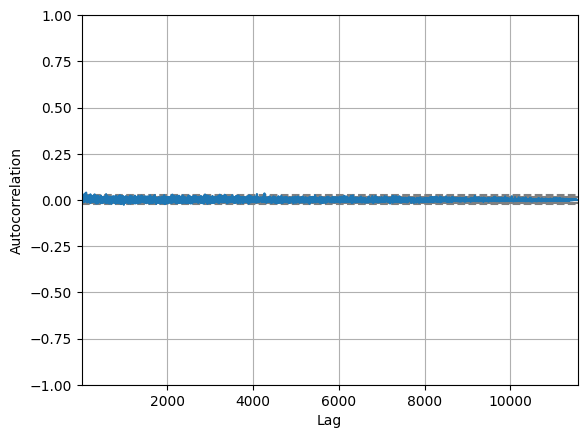

In [4]:
# test = data[['release_date','adj_revenue_millions']]
# test['release_date'] = pd.to_datetime(test['release_date'], format="%Y-%M-%d")
# test  = test.set_index('release_date')
# test.index = pd.DatetimeIndex(test.index).to_period('M')
# #test.index = test.index.to_timestamp()
# test = test.sort_index()
# autocorrelation_plot(test)
# plt.show()

In [5]:
# from statsmodels.tsa.arima.model import ARIMA
#
# model = ARIMA(test, order=(10,1,0))
# model_fit = model.fit()

In [6]:
# print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     adj_revenue_millions   No. Observations:                11573
Model:                  ARIMA(10, 1, 0)   Log Likelihood              -79331.912
Date:                  Sat, 02 Dec 2023   AIC                         158685.824
Time:                          10:08:01   BIC                         158766.744
Sample:                      01-31-1970   HQIC                        158713.017
                           - 01-31-2023                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9231      0.008   -117.112      0.000      -0.939      -0.908
ar.L2         -0.8286      0.010    -81.138      0.000      -0.849      -0.809
ar.L3         -0.7425      0.012    

I am going to use a random forest regressor to try to predict revenue based on genre, runtime, release month, and the number of common words in the synopsis. I will then save the model, and in the website I will run the model 12 times with a different release month each time, use the other parameters based on the user input and return the model from the release month that predicted the highest revenue.

In [7]:
X = data[['runtime','Documentary','action_adv_war_west','horror_thriller','family_animate','scifi_fantasy','hist_drama','crime_mystery','comedy_romance_music','release_month','common_word_count']]
y = data['adj_revenue_millions']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

the distribution of the revenue data is wildly imbalanced and has some extreme outliers. random forest regression is tolerant to outliers though so we don't have to worry about it.

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=2)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [10]:
from sklearn import metrics

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 103.15717292645824
Mean Squared Error (MSE): 30393.919132196264
Root Mean Squared Error (RMSE): 174.338518785139
Mean Absolute Percentage Error (MAPE): 1632.55
Accuracy: -1532.55


The MAPE of this model is extraordinarily high, which is likely because some of the predictions are overshooting or undershooting by such a high degree that the average is thrown off completely. The RMSE is still quite high, but perhaps slightly more acceptable than the MAPE would indicate. This particular research question is not well answered by this data. There are many factors that contribute to the success of a film, and it is not surprising that it is difficult to tell in advance how a film will perform, especially absent the contextual information about the cultural significance (e.g. superhero movies perform better than other action movies, franchise movies perform differently than ones with unknown characters and stories, etc etc). This model is not strong at predicting revenue, but I will still use it in searching for the best month in which to release a film. The exact revenue number is unreliable, but perhaps a small trend will still be useful. Going to perform a randomized search and then a grid search to tune hyperparameters.

In [13]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
max_features = [ 1,'sqrt']
max_depth = [int(x) for x in np.linspace(10,110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,8,10,12]
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid, n_iter=50, cv=3, verbose=2)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=   5.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=   5.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=   5.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=288; total time=   1.8s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=288; total time=   1.8s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=288; total time=   1.8s
[CV] END bootstrap=False, max_depth=40, max_features=1, min_samples_leaf=1, min_samples_split=10, n_estimators=28

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 5, 8, 10, 12],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   verbose=2)

In [15]:
rf_random.best_params_

{'n_estimators': 555,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 1,
 'max_depth': 80,
 'bootstrap': True}

In [16]:
from sklearn.model_selection import GridSearchCV
n_estimators = [500, 525, 550, 575, 600]
max_features = [1]
max_depth = [70, 80, 90]
max_depth.append(None)
min_samples_split = [8, 9, 10, 11, 12]
min_samples_leaf = [1,2,3]
bootstrap = [True]

second_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [18]:
rf = RandomForestRegressor()

rf_grid = GridSearchCV(estimator = rf, param_grid=second_grid, cv=3, verbose=2)

rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] END bootstrap=True, max_depth=70, max_features=1, min_samples_leaf=1, min_samples_split=8, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=70, max_features=1, min_samples_leaf=1, min_samples_split=8, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=70, max_features=1, min_samples_leaf=1, min_samples_split=8, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=70, max_features=1, min_samples_leaf=1, min_samples_split=8, n_estimators=525; total time=   2.5s
[CV] END bootstrap=True, max_depth=70, max_features=1, min_samples_leaf=1, min_samples_split=8, n_estimators=525; total time=   2.5s
[CV] END bootstrap=True, max_depth=70, max_features=1, min_samples_leaf=1, min_samples_split=8, n_estimators=525; total time=   2.5s
[CV] END bootstrap=True, max_depth=70, max_features=1, min_samples_leaf=1, min_samples_split=8, n_estimators=550; total time=   2.6s
[CV] E

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [70, 80, 90, None],
                         'max_features': [1], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [8, 9, 10, 11, 12],
                         'n_estimators': [500, 525, 550, 575, 600]},
             verbose=2)

In [19]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 550}

In [20]:
model_best = RandomForestRegressor(n_estimators=550,
                              min_samples_split=10,
                              min_samples_leaf=1,
                              max_features=1,
                              max_depth=80,
                              bootstrap=True)

model_best.fit(X_train,y_train)

y_pred = model_best.predict(X_test)

In [21]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 95.22948482716419
Mean Squared Error (MSE): 27451.194512092734
Root Mean Squared Error (RMSE): 165.68402008670822
Mean Absolute Percentage Error (MAPE): 1337.83
Accuracy: -1237.83


this is the best I'm going to do with this model setup, so I'm going to pickle it so that it can be used in my stuff later on.

In [26]:
with open('model.pkl', 'wb') as f_pickle:
    pickle.dump(model_best, f_pickle)